## Preparando los datos

Descargar los datos:

https://archive.ics.uci.edu/ml/datasets/bank+marketing



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('data/bank/bank.csv',sep=';')
df['y'] = df['y'].replace('yes',1).replace('no',0) #cambiamos a valores numericos para facilitar el trabajo
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


## Undersampling

In [6]:
#undersampling para equilibrar los 'sies' y 'noes'
df_no = df[df['y'] == 0]
df_yes = df[df['y'] == 1]
df_no_reduced = df_no.sample(df_yes.shape[0],random_state=103)
df_reduced = pd.concat([df_no_reduced,df_yes],axis=0) #reducimos los 'noes' para que haya tantos como 'sies'
df_reduced = df_reduced.sample(frac=1,random_state=103) #con frac los mezclamos
df_reduced.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3437,26,services,single,secondary,no,209,yes,no,cellular,22,jul,319,2,-1,0,unknown,0
4125,30,technician,married,secondary,no,-393,yes,yes,cellular,16,jul,435,1,-1,0,unknown,1
4416,32,blue-collar,single,secondary,no,811,yes,no,cellular,14,may,563,1,-1,0,unknown,1
1532,33,technician,married,secondary,no,133,no,no,cellular,4,may,218,1,-1,0,unknown,1
1017,49,blue-collar,married,secondary,no,-454,yes,no,cellular,14,may,558,1,-1,0,unknown,1


In [7]:
df_reduced.y.value_counts() #hay 521 'sies' y 521 'noes' y ya les tenemos mezclados

1    521
0    521
Name: y, dtype: int64

## Spliting

In [8]:
X = df_reduced[['duration','age']]
y = df_reduced['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=103)

In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)

## Metrics

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score 
print(accuracy_score(y_test,y_test_hat))
print(classification_report(y_test,y_test_hat))

0.7238372093023255
              precision    recall  f1-score   support

           0       0.69      0.82      0.75       176
           1       0.77      0.62      0.69       168

    accuracy                           0.72       344
   macro avg       0.73      0.72      0.72       344
weighted avg       0.73      0.72      0.72       344



# Curvas ROC

Curva de Característica Operativa del Receptor, o Curve The Receiver Operating Characteristic Curve, mejor conocida como ROC, es un método adicional para medir la calidad de un modelo de clasificación binario.

Para graficarlo se contrasta el TPR contra FPR para cada probabilidad de predicción:

#### Recall o true positive rate (TPR)

Porcentaje de casos positivos correctamente clasificados
(Si y era Si)
$$TPR=\frac{TP}{TP+FN}$$

#### fall-out o false positive rate (FPR)

Porcentaje de casos negativos incorrectamente clasificados
(Si y era No)
$$FPR=\frac{FP}{FP+TN}$$

Después se calcula el área bajo la curva. Entre más área mejor el modelo.

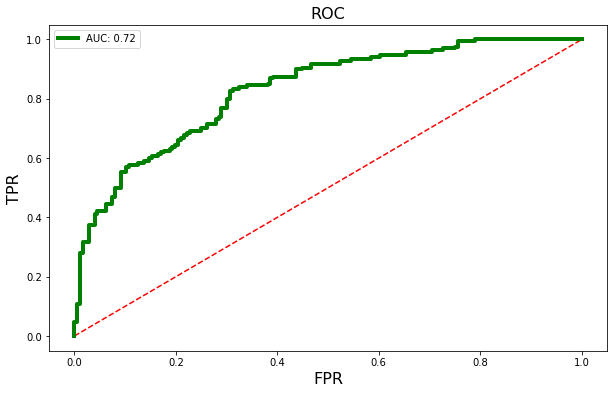

In [11]:
#cuanto mas área quede bajo nuestro curva ROC mejor será el modelo

from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], 'r--')

probs = clf.predict_proba(X_test)

probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,probs)
roc_auc = roc_auc_score(y_test, y_test_hat)

label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC', fontsize = 16)
plt.legend();

#interpretación: si el modelo es malo la linea verde iria cerca de la roja
#si la linea verda subiera casi hasta 1 de golpe seguramente haya overfitting

Regla de dedo para un área bajo la curva en una curva ROC es:

- [0.5]: Equivalente a aleatorio.
- [0.5, 0.6): Test malo.
- [0.6, 0.75): Test regular.
- [0.75, 0.9): Test bueno.
- [0.9, 0.95): Test muy bueno.
- [0.95, 1): Muy bueno para ser cierto.

# Cumulative Accuracy Profile CAP

El perfil de precisión acumulativa o CAP se utiliza para visualizar el poder discriminativo de un modelo. El CAP de un modelo representa el número acumulado de resultados positivos a lo largo del eje y versus el número acumulado correspondiente de un parámetro de clasificación a lo largo del eje x.

In [12]:
df_cap = df.sample(1000,random_state=20)
cap_X = df_cap[['duration','age']]
df_cap.y.value_counts()
#en este dataset hay 100 personas de las que 900 diran que NO y 100 que SI

0    900
1    100
Name: y, dtype: int64

87

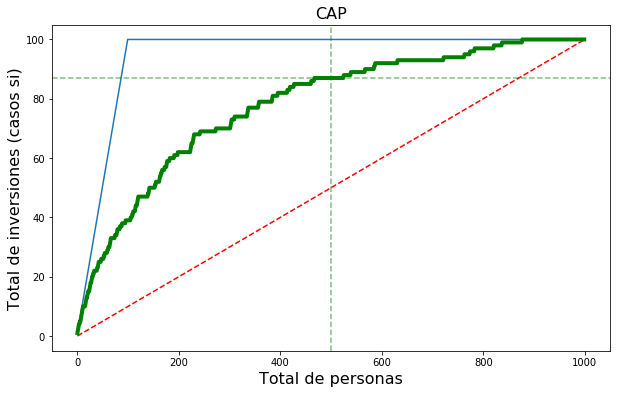

In [15]:
df_cap = df.sample(1000,random_state=20)
cap_X = df_cap[['duration','age']]

plt.figure(figsize = (10, 6))
plt.plot([0,1000], [0,100], 'r--');
# # -------------------------------------
#vamos a pintar en azul ver como sería en un mundo perfecto, con 100% de éxito.
perfect_model = np.cumsum(np.repeat(1,100))
perfect_model.resize(1000)
perfect_model[100:] = 100
perfect_model
plt.plot(perfect_model);
# # -------------------------------------
#nuestro modelo en la realidad
df_cap['probs'] = clf.predict_proba(cap_X)[:, 1] #solo queremos los 'sies' [:, 1]
df_cap = df_cap.sort_values(by='probs',ascending=False)
probs = np.cumsum(df_cap.y).values
plt.plot(probs,c = 'g', label = label, linewidth = 4);
#lo que nos enseña es que llamando a 400 clientes habremos llamado al 80% de las personas que predice nuestro modelo
# # -------------------------------------
plt.xlabel('Total de personas', fontsize = 16)
plt.ylabel('Total de inversiones (casos si)', fontsize = 16)
plt.title('CAP', fontsize = 16)
plt.axvline(x=500, color='g', linestyle='--',alpha=0.5)
plt.axhline(y=probs[499], color='g', linestyle='--',alpha=0.5)
probs[499]
#si llamamos a 500 personas abremos llamado al 87% aprox de los 'sies'

- [0,0.6]: Equivalente a aleatorio o peor.
- [0.6, 0.7): Test malo.
- [0.7, 0.8): Test bueno.
- [0.8, 0.90): Test muy bueno.
- [0.90, 1): Muy bueno para ser cierto.

In [10]:
df_reduced.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3437,26,services,single,secondary,no,209,yes,no,cellular,22,jul,319,2,-1,0,unknown,0
4125,30,technician,married,secondary,no,-393,yes,yes,cellular,16,jul,435,1,-1,0,unknown,1
4416,32,blue-collar,single,secondary,no,811,yes,no,cellular,14,may,563,1,-1,0,unknown,1
1532,33,technician,married,secondary,no,133,no,no,cellular,4,may,218,1,-1,0,unknown,1
1017,49,blue-collar,married,secondary,no,-454,yes,no,cellular,14,may,558,1,-1,0,unknown,1


En general cuando construimos modelos predictivos, los métodos usados asumen que los datos son cuantitativos. Por ejemplo, variables como edad o saldo. En realidad, los datos pueden venir en forma categórica, por ejemplo, estado civil, genero, nivel de educación entre otros. Nosotros como científicos de datos podemos transformar los datos categóricos a numéricos para permitir a los algoritmos manejarlos más fácilmente pues recordemos que en realidad los modelos creados representan una función matemática.

Para ello tenemos dos alternativas:
 - Asignarles un valor numérico secuencial. Solo se puede utilizar cuando las categorías tienen un orden natural como por ejemplo el nivel de educación.
 - Utilizar variables ficticias o dummy.
 
 # Variables Dummy
 
Una variable ficticia es una variable artificial para representar una variable categórica con dos o más categorías.


In [11]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


In [12]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object

In [13]:
columns_to_dummy = df.columns[df.dtypes == np.object] #seleccionamos las columnas de tipo texto
columns_to_dummy

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [14]:
df_w_dummy = pd.get_dummies(df,prefix=columns_to_dummy)
df_w_dummy.head() #gracias a get.dummies hemos cambiado todas las columnas de tipo texto, para cada tipo de valor nos generara una columna nueva

,age,balance,day,duration,campaign,pdays,previous,y,job_admin.,job_blue-collar,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1


In [15]:
df_w_dummy.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

### Trampa de las variables ficticias

La trampa de las variables ficticias es un escenario en el cual dos o mas variables independientes son multicolineales, en términos más sencillos, es cuando con una variable podemos predecir la o las otras. La consecuencia de utilizar variables multicolineales es que nuestro modelo no pueda utilizar correctamente esa información. 


Para evitar caer en la trampa de la variable ficticia, una regla de dedo es utilizar una variable ficticia menos que el número de categorías.  Afortunadamente Python lo puede hacer de forma automática.


In [16]:
#con drop_first elimina columnas que podemos deducir por ejemplo:
 #si no es casado, ni es soltero, es que será divorciado
df_w_dummy = pd.get_dummies(df,prefix=columns_to_dummy,drop_first=True)
df_w_dummy.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,30,1787,19,79,1,-1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,33,4789,11,220,1,339,4,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,35,1350,16,185,1,330,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30,1476,3,199,4,-1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,59,0,5,226,1,-1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [17]:
df_w_dummy.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'y', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes', 'housing_yes',
       'loan_yes', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [18]:
#UnderSampling
df_no = df_w_dummy[df_w_dummy['y'] == 0]
df_yes = df_w_dummy[df_w_dummy['y'] == 1]
df_no_reduced = df_no.sample(521,random_state=103)
df_reduced = pd.concat([df_no_reduced,df_yes],axis=0)
df_reduced = df_reduced.sample(frac=1,random_state=103)
df_reduced = df_reduced.astype('float')
df_reduced.head()

,age,balance,day,duration,campaign,pdays,previous,y,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
3437,26.0,209.0,22.0,319.0,2.0,-1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4125,30.0,-393.0,16.0,435.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4416,32.0,811.0,14.0,563.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1532,33.0,133.0,4.0,218.0,1.0,-1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1017,49.0,-454.0,14.0,558.0,1.0,-1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# Selección de características

Una vez que ya tratamos con las variables categóricas, nos quedo un conjunto de datos con 43 variables. Seguramente algunas de ellas son completamente irrelevantes, es decir, no aportan nada o casi nada a nuestros modelos predictivos. Estas variables irrelevantes pueden dar problemas a nuestras estimaciones. Las variables irrelevantes:
- Desperdician memoria RAM.
- Actúan como ruido.
- Aumentan el tiempo de entrenamiento.

Una solución a este problema es la selección de características relevantes. Que es básicamente el proceso de seleccionar las variables o características más relevantes de un conjunto de datos. Hay básicamente tres tipos de métodos de selección de características:
- Métodos de filtrado: Son aquellos que utilizan medidas estadísticas para ordenar las variables por su significancia.
- Métodos de envoltura: Son aquellos que utilizan modelos predictivos par determinar la calidad de las variables seleccionadas.
- Métodos integrados: Son aquellos que incorporan el proceso de selección en la fase de entrenamiento del modelo predictivo. El ejemplo más común es el árbol de decisión.

La selección de métodos de envoltura, se realizan usualmente a manera de prueba y error y además de manera iterativa. Esta técnica se conoce como selección paso a paso o stepwise. 
Es importante recalcar que selección de características es diferente a la reducción de dimensionalidad. Aunque ambos métodos buscan reducir el número de características, la reducción de dimensionalidad lo hace transformando el conjunto de datos completo. Esto está fuera de las intenciones de este cuaderno, pero es bueno saber que existe una diferencia desde ahora.

No confudir envoltura con la reducción de dimensionalidad.


<img src="img/forward.png" alt="Forward Selection" >
<center><h3>Forward Selection</h3></center>

<br><br><br><br><br>

<img src="img/backward.png" alt="Backward Selection">
<center><h3>Backward Selection</h3></center>

In [20]:
#si tenemos 50 columnas ha de hacer 50 simulaciones, para acelerar el proceso escalamos datos con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X = df_reduced.drop("y",axis=1)
y = df_reduced.y
X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=103)

In [21]:
from sklearn.feature_selection import RFE #recursive feature elimination

estimator = LogisticRegression(solver='lbfgs')
selector = RFE(estimator, 8, step=1) #nos queremos quedar con 8 variables y eliminalas de 1 en 1
selector = selector.fit(X_train, y_train.ravel())

print(selector.support_) #8 True: son las 8 columnas que ha determinado como mas relevantes
print(selector.ranking_) #para determinar los datos de mayor relevancia


[False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False  True False False  True
  True  True False False  True False]
[10  8 28  1  1 27 11  5 30 13 23  3 22 35 21  9  4 34 18 19 24 29 26 33
 14 12 16  1 15 31 32  2  1 25  6  1  1  1 17 20  1  7]


In [22]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,0


In [23]:
best_variables = selector.support_
df_reduced.loc[:, best_variables].head()
#ya tenemos un dataset con las 8 columnas relevantes

,duration,campaign,contact_telephone,month_jan,month_mar,month_may,month_nov,poutcome_other
3437,319.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4125,435.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4416,563.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1532,218.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1017,558.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
clf = LogisticRegression(solver='lbfgs').fit(X_train[:,best_variables], y_train.ravel())
y_test_hat = clf.predict(X_test[:,best_variables])

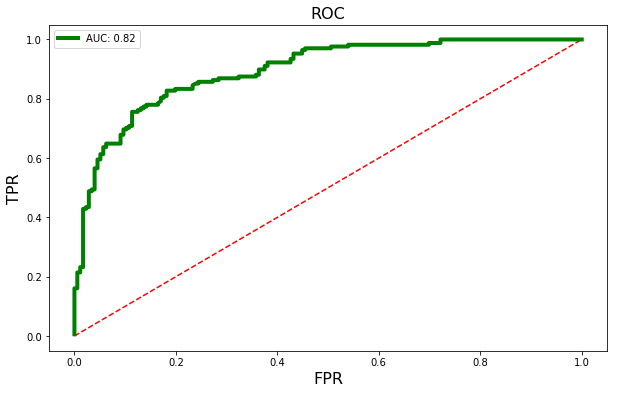

In [25]:
plt.figure(figsize = (10, 6))
plt.plot([0,1], [0,1], 'r--')

probs = clf.predict_proba(X_test[:,best_variables])
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,probs)
roc_auc = roc_auc_score(y_test, y_test_hat)
label = 'AUC:' + ' {0:.2f}'.format(roc_auc)
plt.plot(fpr, tpr, c = 'g', label = label, linewidth = 4)
plt.xlabel('FPR', fontsize = 16)
plt.ylabel('TPR', fontsize = 16)
plt.title('ROC', fontsize = 16)
plt.legend();

#CONCLUSION: teniamos una precision de 0,72 ahora 0,82 gracias al uso de variables dummy y a la seleccion de características